# A Latent Space Model for Hypergraphs

* Let $G=(V,E)$ be a hypergraph, where $E$ is the collection of hyperedges.
* Let $H$ be the collection of admisible sets of nodes, (e.g., if we only consider hyperedges of size less than 10). 
* $G$ is modeled as a collection of random variables ${X_h: h\in H}$.
* $X_h\sim Poisson(\lambda_h)$, which means we allow multi-hyperedges.
* The rate $\lambda_h$ depends on the features of nodes in $h$: $$\lambda_h=|h|^\alpha\sum_k\prod_{i\in h}\theta_{ik},$$ where $\theta_i$: the latent feature vector for node $i$.
* Assume $X_h$'s are independent of each other given $\theta=(\theta_i)$.
* The distribution of $G$ is given by $$p(G|\theta)=\prod_{h\in H} p(x_h|\theta)$$.
* Take a Bayesian approach to estimate $\theta$ and sample $\theta$ from the posterior using MCMC.
    * Propose $\theta'$.
    * Draw $G'$ given $\theta'$.
        * Start from $G$.
        * Every step pick $h\in H$ at random.
        * Draw $X_e$ from $Poisson(\lambda_h(\theta'))$.
    * Move to $\theta'$ with probability $\rho$.

In [223]:
%matplotlib inline
import pylab as plt
import numpy as np
import scipy.sparse as ssp
import random
from collections import Counter
from scipy.stats import dirichlet, truncnorm
import sys
import pickle
import time
from string import lower
from itertools import combinations, izip, chain
from collections import Counter
from scipy.stats import pearsonr, norm, poisson
from scipy.misc import comb

In [5]:
class Stopwatch:
    start_time=None
    def go(self,msg=''):
        if msg:
            print msg,
        self.start_time=time.time()
        sys.stdout.flush()
    def stop(self,msg=''):
        if msg:
            print "{}: {} seconds".format(msg,time.time()-self.start_time)
        else:
            print "Elapsed time: {} seconds".format(time.time()-self.start_time)
        sys.stdout.flush()
    def check(self):
        return time.time()-self.start_time


def LoadDate(filename):
    tic=Stopwatch()
    print "Loading paper dates %s from disk..." % filename,
    tic.go()
    pkl_file = open(filename, 'rb')
    A=pickle.load(pkl_file)
    pkl_file.close()
    tic.stop()
    return A


def LoadData(filename):
    tic=Stopwatch()
    print "Loading file %s from disk..." % filename,
    tic.go()
    pkl_file = open(filename, 'rb')   
    (row,col) = pickle.load(pkl_file)        
    pkl_file.close()
    A=ssp.coo_matrix((np.ones(len(row),dtype=np.int8),(row,col)),shape=(19916562,col.max()+1),dtype=np.float)
    tic.stop()
    return A

### Initialization

* Read in the hypergraph of Medline

In [7]:
tic=Stopwatch()

tic.go('Loading citation data...')
citations=pickle.load(open('../hypergraph/citations.pkl'))
tic.stop()
# Load hypergraphs
thing=['Author','Chemical','Disease','Method']
G=[]
for i in range(1,4):
    G.append(LoadData('../hypergraph/'+lower(thing[i])+'.pkl'))
G=ssp.hstack(G).tocsr()

paper_dates=LoadDate('../hypergraph/date.pkl') # Load publicatioin dates

id2chemical=pickle.load(open('../hypergraph/Citation/id2chemical.pkl'))
id2disease=pickle.load(open('../hypergraph/Citation/id2disease.pkl'))
id2method=pickle.load(open('../hypergraph/Citation/id2method.pkl'))
id2name=np.array(id2chemical+id2disease+id2method)

Loading paper dates ../hypergraph/date.pkl from disk... Elapsed time: 6.54103779793 seconds


In [350]:
G0=G[((paper_dates==1970)).nonzero()[0],:]
E0=Counter((tuple(row.nonzero()[1]) for row in G0 if row.size>0)) # set of hyperedges

In [355]:
rows=random.sample(E0.keys(),10000)
E=Counter()
for i in rows:
    E[i]=E0[i]

In [377]:
M = len(E) # number of edges
V = sorted(set(chain(*(E.keys())))) #range(G0.shape[1]) # list of nodes
N = max(V)+1 # number of nodes
K = 30 # dimension of hidden space
averageSize=3
sigma=0.1
#theta = truncnorm.rvs((0-1.0/K)/sigma,(1-1.0/K)/sigma,1.0/K,sigma,size=(K,N))
#theta=theta/theta.sum(axis=0)
theta = np.random.dirichlet([10]*K,size=N).T * degree

alpha=1

In [378]:
def Lambda(e,theta,alpha):
    return theta[:,list(e)].prod(axis=1).sum()*(len(e)**alpha)

def proposeG(givenE,averageSize):
    if random.random()<0.5: # choose an edge
        e=random.choice(givenE.keys())
        X=np.random.poisson(Lambda(e,theta,alpha))
    else: # choose a nonedge
        while True:
            n=np.random.poisson(averageSize)
            e=tuple(sorted(random.sample(V,min(max(n,1),N))))
            if e not in givenE:
                break
        X=np.random.poisson(Lambda(e,theta,alpha))
    return (e,X)
    
def sampleG(theta,alpha,E):
    change=Counter()
    for i in xrange(20000):
        n=np.random.poisson(averageSize)
        e=tuple(sorted(random.sample(V,min(max(n,1),N))))
        lambdae=Lambda(e,theta,alpha)
        if lambdae==0:
            X=0
        else:
            X=np.random.poisson(lambdae)
        if e not in change:
            if E[e]!=X:
                change[e]=X
        else:
            if change[e]!=X:
                change[e]=X
    
    return change

#### Simulate $\theta$

In [ ]:
aRate=0.0
for i in xrange(5000):
    # Propose new theta
    thetaP = np.random.dirichlet([10]*K,size=N).T * degree
    #thetaP=np.array([ [truncnorm.rvs((0-i)/sigma,(1-i)/sigma,i,sigma) for i in k] for k in theta])
    #thetaP=thetaP/thetaP.sum(axis=0)
    # Sample G' from new theta
    EP=sampleG(theta,alpha,E)
    # Calculate transition probability
    rho=1.0
    for e in EP:
        lambdae=Lambda(e,theta,alpha)
        lambdaep=Lambda(e,thetaP,alpha)
        if lambdae==0 or lambdaep==0:
            rho=0
            break
        rho*=(lambdae/lambdaep)**(EP[e]-E[e])
    #rho*=reduce(lambda a,b: a*b, ( truncnorm.pdf(thetaP[j,i],(0-1.0/K)/sigma,(1-1.0/K)/sigma,1.0/K,sigma)/truncnorm.pdf(theta[j,i],(0-1.0/K)/sigma,(1-1.0/K)/sigma,1.0/K,sigma) for i in V for j in xrange(K)))
    #rho*=reduce(lambda a,b: a*b, ( dirichlet.pdf(thetaP[:,i],[10]*K)/dirichlet.pdf(theta[:,i],[10]*K) for i in V ))
    # Move
    if random.random()<rho:
        aRate+=1
        theta=thetaP
    
    # Propose new alpha
    alphaP=abs(alpha+np.random.normal(scale=0.1))
    # Sample G' from new alpha
    EP=sampleG(theta,alphaP,E)
    # Calculate transition probability
    rho=1.0
    for e in EP:
        lambdae=Lambda(e,theta,alpha)
        lambdaep=Lambda(e,theta,alphaP)
        if lambdae==0 or lambdaep==0:
            rho=0
            break
        rho*=(lambdae/lambdaep)**(EP[e]-E[e])
    rho*=norm.pdf(alphaP,1,2)/norm.pdf(alpha,1,2)
    # Move
    if random.random()<rho:
        alpha=alphaP

In [323]:
Counter([len(i) for i in EP.keys()]), aRate, len(EP), alpha

(Counter({1: 1991, 2: 488, 3: 48, 4: 3, 5: 1}),
 4367.0,
 2531,
 0.007770136028110961)

In [371]:
L=[]
samples=[]
LRandom=[]
randomSamples=[]
for e in E:
    if len(e)<2:
        continue
    samples.append(e)
    L.append(poisson.pmf(E[e],Lambda(e,theta,alpha)))
    while True:
        n=len(e)#np.random.poisson(len(e))
        e0=tuple(sorted(random.sample(V,min(max(n,1),N)),reverse=True))
        if e0 not in E0:
            break
    randomSamples.append(e0)
    LRandom.append(poisson.pmf(1,Lambda(e0,theta,alpha)))

([array([ 8531.,    95.,   967.,    30.,    33.,    35.,    24.,    24.,
            16.,    27.]),
  array([  8.39600000e+03,   7.30000000e+01,   1.21100000e+03,
           2.00000000e+00,   3.60000000e+01,   8.00000000e+00,
           1.00000000e+01,   1.00000000e+01,   1.70000000e+01,
           1.90000000e+01])],
 array([  2.51102738e-237,   3.67879418e-002,   7.35758836e-002,
          1.10363825e-001,   1.47151767e-001,   1.83939709e-001,
          2.20727651e-001,   2.57515593e-001,   2.94303534e-001,
          3.31091476e-001,   3.67879418e-001]),
 <a list of 2 Lists of Patches objects>)

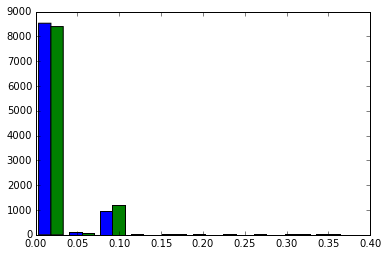

In [372]:
plt.hist([L,LRandom])

In [373]:
max(L),max(LRandom)

(0.36787703964604224, 0.36787941809128688)

In [374]:
zip(randomSamples,samples)

[((13756, 10779, 10390, 9488, 9395, 4963, 4798),
  (14734, 14427, 14202, 10882, 10477, 2439, 2024)),
 ((10673, 9201, 4507, 3986, 2118, 1614),
  (13584, 11660, 9884, 3806, 3487, 533)),
 ((15569, 10301, 9234, 2356, 533), (14362, 2526, 1929, 423, 416)),
 ((14544, 11249, 9499), (11763, 2528, 1879)),
 ((14879, 11808, 11352, 645), (13786, 4400, 4149, 572)),
 ((14099, 9366, 4699, 3544, 3517), (14658, 3809, 3492, 1035, 328)),
 ((11120, 9754, 3734, 3247, 2854, 1873, 252),
  (11923, 11449, 10846, 9779, 9667, 2465, 2066)),
 ((14371, 13268, 11152, 10385, 88), (14506, 14172, 13992, 13644, 11989)),
 ((13839, 13672, 11354, 10090, 9736, 3487),
  (14377, 14076, 13983, 2681, 2236, 1144)),
 ((9944, 9554, 4608, 4306, 4106), (14819, 13915, 13890, 13879, 1365)),
 ((11096, 10187, 4608, 4453, 1527), (14862, 9797, 5015, 1922, 1368)),
 ((9811, 9673, 4862, 4198, 2357), (14766, 14477, 9320, 3339, 489)),
 ((9691, 4866, 693), (13606, 11127, 9673)),
 ((4521, 3075), (86, 22)),
 ((12002, 3551, 1500, 1431, 995), (14747

In [375]:
Lambda((14544, 11249, 9499),theta,alpha), Lambda( (11763, 2528, 1879),theta,alpha)

(0.011106660781524863, 0.010132116349640903)

In [376]:
theta[:,list((14544, 11249, 9499))],theta[:,list( (11763, 2528, 1879))]

(array([[ 0.14020568,  0.13735834,  0.1532921 ],
        [ 0.11711112,  0.09842139,  0.09346279],
        [ 0.09134493,  0.11477203,  0.1592111 ],
        [ 0.12981419,  0.05562573,  0.09316122],
        [ 0.0924254 ,  0.10841821,  0.10934015],
        [ 0.0768442 ,  0.08813746,  0.12941284],
        [ 0.12361169,  0.13715082,  0.07813466],
        [ 0.09889652,  0.1031714 ,  0.06611773],
        [ 0.09677144,  0.10136836,  0.06333409],
        [ 0.03297483,  0.05557628,  0.05453331]]),
 array([[ 0.10412332,  0.08528995,  0.10901858],
        [ 0.11135662,  0.0663478 ,  0.12598311],
        [ 0.11882654,  0.12934134,  0.0938702 ],
        [ 0.14573427,  0.11408598,  0.08492289],
        [ 0.09613103,  0.09538349,  0.10961133],
        [ 0.08028095,  0.09396808,  0.13437609],
        [ 0.11841339,  0.07188327,  0.04826008],
        [ 0.07566892,  0.19665976,  0.13323024],
        [ 0.07025754,  0.066346  ,  0.05775864],
        [ 0.07920741,  0.08069434,  0.10296884]]))